# Operator Learing - Fourier Neural Operator

Solutions of PDEs are operators that act as mappings between function spaces. They take initial conditions, boundary conditions, and source terms as inputs and yield the PDE solution as output.

In **operator learning**, models are tasked with handling functions as inputs and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

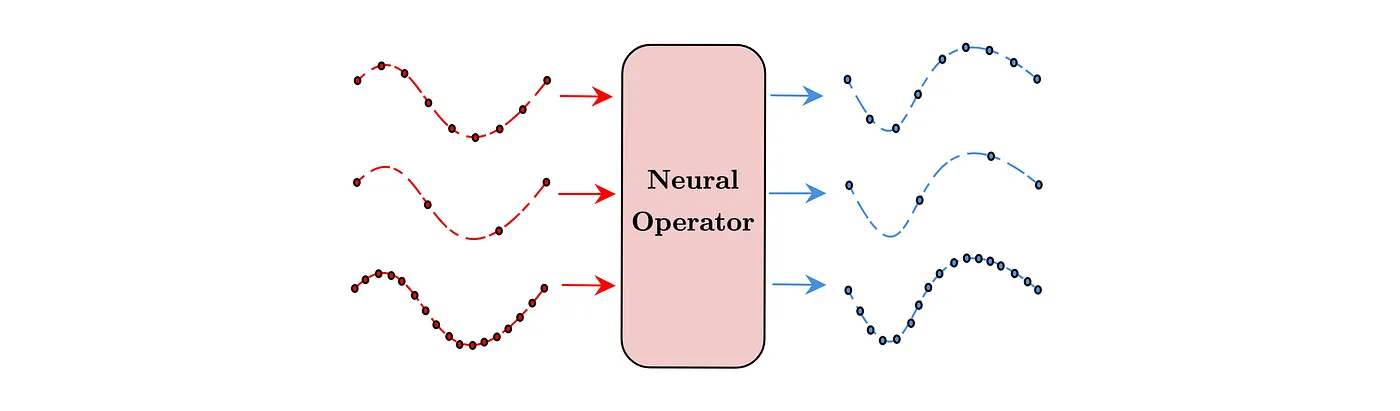



In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from utilities import LprelLoss

## Allen-Cahn equation

We will solve Allen-Cahn equation:
$$u_t = \Delta u - ϵ^2 u (u^2 - 1),\quad u\in\mathbb{R}×\mathbb{R_{>0}}$$
Operator that we wish to learn is
$$\mathcal{G}: u(\cdot, t = 0) \mapsto  u(\cdot, t = 1)$$
Note that the data is generated for you (see the files *AC_data_input.npy* and *AC_data_output.npy*).

In [2]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
n_train = 800 # number of training samples

# Load the data
x_data = torch.from_numpy(np.load("AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("AC_data_output.npy")).type(torch.float32)

input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
print("Input shape train: ", input_function_train.shape)
print("Output shape train: ", output_function_train.shape)

input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]
print("Input shape test: ", input_function_test.shape)
print("Output shape test: ", output_function_test.shape)


Input shape train:  torch.Size([800, 1001, 2])
Output shape train:  torch.Size([800, 1001])
Input shape test:  torch.Size([200, 1001, 2])
Output shape test:  torch.Size([200, 1001])


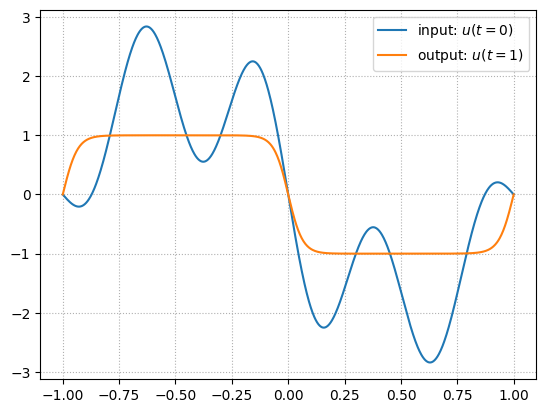

In [4]:
id_sample = 32

plt.plot(np.linspace(-1, 1, input_function_train.shape[1]),input_function_train[id_sample,:,1], label = "input: $u(t = 0)$")
plt.plot(np.linspace(-1, 1, input_function_train.shape[1]),output_function_train[id_sample,:], label = "output: $u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

In [5]:
batch_size = 10
training_set = DataLoader(
    TensorDataset(input_function_train, output_function_train), 
    batch_size=batch_size, 
    shuffle=True,
    generator=torch.Generator(device=device))
testing_set = DataLoader(
    TensorDataset(input_function_test, output_function_test), 
    batch_size=batch_size, 
    shuffle=False,
    generator=torch.Generator(device=device))

## Fourier Neural Operator (FNO)

- Introduced in the paper [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).
- First layer is the **lifting layer** (in the channel dimension, increases the number of channels), while the last layer is the **projection layer** (reduces the number of channels). The hidden layer of FNO is formulated as an **iterative architecture**.
- FNO uses **convolutions** parametrized in the **frequency domain** (**global** operations)

The Fourier layer just consists of three steps:

1. Fourier transform (using FFT)

2. Linear transform on the lower Fourier modes

3. Inverse Fourier transform

<img src="./FNO_architecture.png">

<video src="./FNO_architecture.mp4" controls>
    Your browser does not support the video tag.
</video>

Here we define Fourier layer in 1d (or spectral convolution)

In [6]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

Here we define the *FNO1d*, that uses *SpectralConv1d* as its crucial part.

In [7]:
class FNO1d(nn.Module):
    def __init__(self, modes, width, L, activation):
        super(FNO1d, self).__init__()

        self.modes = modes
        self.width = width
        self.L = L
        self.activation = activation
        self.padding = 1  # pad the domain if input is non-periodic

        # Lifting operator
        self.lifting_layer = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x). Grid is included in the dataset

        # L layers of FNO block
        self.spects = nn.ModuleList([SpectralConv1d(self.width, self.width, self.modes) for _ in range(self.L)])
        self.linears = nn.ModuleList([nn.Linear(self.width, self.width) for _ in range(self.L)])

        # Output layer
        self.output_layer = nn.Linear(self.width, 1)

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def forward(self, x):
        x = self.lifting_layer(x)

        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])

        for i in range(self.L):
            x1 = self.spects[i](x)
            x2 = self.linears[i](x.permute(0, 2, 1))
            x2 = x2.permute(0, 2, 1)
            if i < self.L - 1:
                x = self.activation(x1 + x2)

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 1)

        x = self.output_layer(x)
        return x


Define an FNO with 16 modes, 64 as hidden dimension and 3 layers.

In [8]:
modes = 16
width = 64
L = 3
activation = nn.Tanh()

fno = FNO1d(modes, width, L, activation)
fno

FNO1d(
  (activation): Tanh()
  (lifting_layer): Linear(in_features=2, out_features=64, bias=True)
  (spects): ModuleList(
    (0-2): 3 x SpectralConv1d()
  )
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

## Training

Here we define the hyper-parameters for training.

In [9]:
learning_rate = 0.001
epochs = 50
step_size = 50
gamma = 0.5
freq_print = 1 # print frequency

Now we define the function to makes the training

In [10]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss = LprelLoss(2, False)
try:
    print(f"We have already train the model for {len(loss_values)} epochs.")
except:
    loss_values = []

for epoch in range(epochs):
    train_mse = 0.0

    for step, (input_batch, output_batch) in enumerate(training_set):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze()
        loss_f = loss(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()

    train_mse /= len(training_set)
    loss_values.append(train_mse)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0

        for step, (input_batch, output_batch) in enumerate(testing_set):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output_pred_batch = fno(input_batch).squeeze()
            loss_f = loss(output_pred_batch, output_batch)
            test_relative_l2 += loss_f.item()

        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: 
        print("### Epoch:", epoch,
              " ### Train Loss:", train_mse,
              "### Relative L2 Test Norm:", test_relative_l2)



### Epoch: 0  ### Train Loss: 2.664826659858227 ### Relative L2 Test Norm: 1.4145178824663163
### Epoch: 1  ### Train Loss: 0.9754967577755451 ### Relative L2 Test Norm: 0.6800605341792106
### Epoch: 2  ### Train Loss: 0.6275538470596075 ### Relative L2 Test Norm: 0.5136189743876457
### Epoch: 3  ### Train Loss: 0.5274027060717345 ### Relative L2 Test Norm: 0.48110717833042144
### Epoch: 4  ### Train Loss: 0.42631491664797067 ### Relative L2 Test Norm: 0.442850661277771
### Epoch: 5  ### Train Loss: 0.37473942469805477 ### Relative L2 Test Norm: 0.42670013159513476
### Epoch: 6  ### Train Loss: 0.33082724511623385 ### Relative L2 Test Norm: 0.26479850709438324
### Epoch: 7  ### Train Loss: 0.2839451363310218 ### Relative L2 Test Norm: 0.28631188049912454
### Epoch: 8  ### Train Loss: 0.29087551962584257 ### Relative L2 Test Norm: 0.25754015147686005
### Epoch: 9  ### Train Loss: 0.291029023565352 ### Relative L2 Test Norm: 0.3324333816766739
### Epoch: 10  ### Train Loss: 0.25161070842

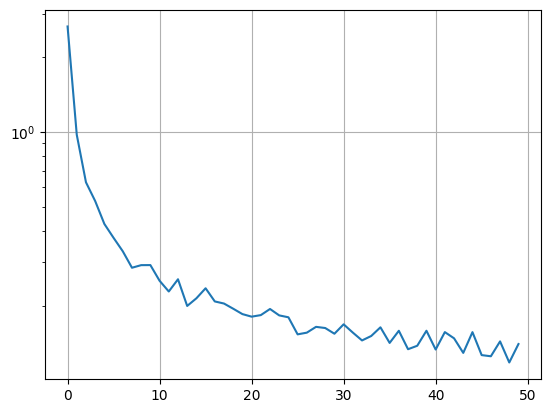

In [11]:
plt.semilogy(range(len(loss_values)), loss_values)
plt.grid()

## Plot

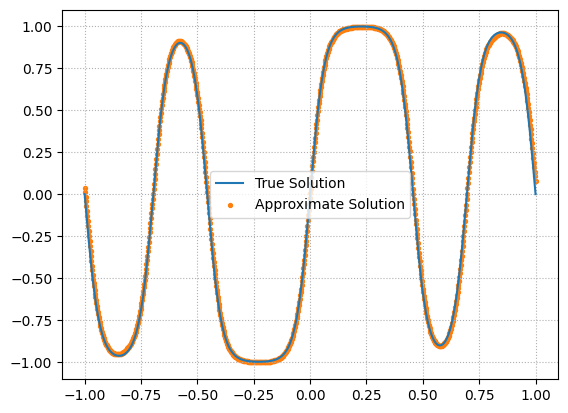

In [12]:
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
#print(input_function_test_n.shape)
#print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n.to(device))
#print(output_function_test_pred_n.shape)
#print(input_function_test_n[0,:,1])
plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,0].detach().cpu(), 
         output_function_test_n[0].detach().cpu(), label="True Solution")
plt.scatter(input_function_test_n[0,:,0].detach().cpu(),
            output_function_test_pred_n[0].detach().cpu(), label="Approximate Solution", s=8, c="C1")
plt.legend()